In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
# Import Austin Animal Center intakes and outcomes - 
aac_df = pd.read_csv("aac_intakes_outcomes.csv")[[
    'animal_id_intake',
    'animal_type',
    'breed',
    'intake_month',
    'intake_weekday',
    'color',
    'age_upon_intake_(years)',
    'intake_type',
    'intake_condition',
    'sex_upon_intake',
    'sex_upon_outcome',
    'time_in_shelter_days', # goal
    'outcome_type'
]]

aac_df.rename(columns={
    "animal_id_intake": "id",
    'age_upon_intake_(years)': 'age_upon_intake_years'
}, inplace=True)

aac_df.head(10)

,id,animal_type,breed,intake_month,intake_weekday,color,age_upon_intake_years,intake_type,intake_condition,sex_upon_intake,sex_upon_outcome,time_in_shelter_days,outcome_type
0,A006100,Dog,Spinone Italiano Mix,12,Thursday,Yellow/White,10.0,Stray,Normal,Neutered Male,Neutered Male,0.588194,Return to Owner
1,A006100,Dog,Spinone Italiano Mix,12,Friday,Yellow/White,7.0,Public Assist,Normal,Neutered Male,Neutered Male,1.259722,Return to Owner
2,A006100,Dog,Spinone Italiano Mix,3,Friday,Yellow/White,6.0,Public Assist,Normal,Neutered Male,Neutered Male,1.113889,Return to Owner
3,A047759,Dog,Dachshund,4,Wednesday,Tricolor,10.0,Owner Surrender,Normal,Neutered Male,Neutered Male,4.970139,Transfer
4,A134067,Dog,Shetland Sheepdog,11,Saturday,Brown/White,16.0,Public Assist,Injured,Neutered Male,Neutered Male,0.119444,Return to Owner
5,A141142,Dog,Labrador Retriever/Pit Bull,11,Saturday,Black/White,15.0,Stray,Aged,Spayed Female,Spayed Female,0.870833,Return to Owner
6,A163459,Dog,Miniature Schnauzer Mix,11,Friday,Black/Gray,15.0,Stray,Normal,Intact Female,Intact Female,0.178472,Return to Owner
7,A165752,Dog,Lhasa Apso Mix,9,Monday,Brown/White,15.0,Stray,Normal,Neutered Male,Neutered Male,0.213194,Return to Owner
8,A178569,Dog,Shetland Sheepdog Mix,3,Monday,White/Black,15.0,Public Assist,Normal,Neutered Male,Neutered Male,6.258333,Return to Owner
9,A189592,Dog,Shetland Sheepdog Mix,9,Friday,Brown/White,18.0,Stray,Normal,Spayed Female,Spayed Female,0.054167,Return to Owner


In [3]:
f'Samples {aac_df.shape[0]}'

'Samples 79672'

In [4]:
# Filter only dogs and cats
aac_df = aac_df[aac_df['animal_type'].str.contains('Dog|Cat')]
aac_df = aac_df[aac_df['animal_type'].str.contains('Dog|Cat')]
aac_df = aac_df[aac_df['outcome_type'] != 'Return to Owner']

f'Samples {aac_df.shape[0]}'

'Samples 60161'

In [5]:
# Convert sex_upon_intake/sex_upon_outcome

# Testing features
n_samples_sex_diff = aac_df[aac_df['sex_upon_intake'] != aac_df['sex_upon_outcome']].shape[0]
print(f'Number of animals with reproductive state changed: {n_samples_sex_diff}')

samples_sex_unknown_io = aac_df.query('sex_upon_intake == "Unknown" & sex_upon_outcome == "Unknown"')
print(f'Number of animals with reproductive state unknown (both intake and outcome): {samples_sex_unknown_io.shape[0]}')

n_samples_sex_unknown_i_no_o = aac_df.query('sex_upon_intake == "Unknown" & sex_upon_outcome != "Unknown"').shape[0]
print(f'Number of animals with intake reproductive state unknown and diff outcome reproductive state: {n_samples_sex_unknown_i_no_o}')

n_samples_sex_unknown_no_i_o = aac_df.query('sex_upon_intake != "Unknown" & sex_upon_outcome == "Unknown"').shape[0]
print(f'Number of animals with outcome reproductive state unknown and diff intake reproductive state: {n_samples_sex_unknown_no_i_o}')

print('If sex_upon_intake is unknown so will be sex_upon_outcome')
print(f'\n--- Percent of animals with unknown sex: {round(samples_sex_unknown_io.shape[0]/aac_df.shape[0], 2)}% ---\n')

n_samples_only_sex_diff = aac_df[ \
    ((aac_df['sex_upon_intake'].str.contains('Male', na=False)) \
    &(aac_df['sex_upon_outcome'].str.contains('Female', na=False))) \
    | \
    (aac_df['sex_upon_intake'].str.contains('Female', na=False)) \
    &(aac_df['sex_upon_outcome'].str.contains('Male', na=False))].shape[0]

print(f'Number of animals with different sex (Male/Female) after io: {n_samples_only_sex_diff}')

print("If sex_upon_intake is Male/Female so will be sex_upon_outcome => all the changes are due to spaying/neutering")


Number of animals with reproductive state changed: 27708
Number of animals with reproductive state unknown (both intake and outcome): 2756
Number of animals with intake reproductive state unknown and diff outcome reproductive state: 0
Number of animals with outcome reproductive state unknown and diff intake reproductive state: 0
If sex_upon_intake is unknown so will be sex_upon_outcome

--- Percent of animals with unknown sex: 0.05% ---

Number of animals with different sex (Male/Female) after io: 0
If sex_upon_intake is Male/Female so will be sex_upon_outcome => all the changes are due to spaying/neutering


In [6]:
# Breaking down features
rsi = 'reproductive_state_intake'
rso = 'reproductive_state_outcome'

aac_df[[rsi, 'sex']] = aac_df['sex_upon_intake'].str.split(expand=True)
aac_df.loc[aac_df['sex'].isna(), 'sex'] = 'Unknown'
aac_df[rso] = aac_df['sex_upon_outcome'].str.split(expand=True)[0]

# group neutered/spayed to sterile
reproductive_state_cols = [rsi, rso]
aac_df[reproductive_state_cols] = aac_df[reproductive_state_cols].replace({'Neutered':'Sterile', 'Spayed':'Sterile'})

aac_df.drop(columns=['sex_upon_intake', 'sex_upon_outcome'], inplace=True)

aac_df.head()

,id,animal_type,breed,intake_month,intake_weekday,color,age_upon_intake_years,intake_type,intake_condition,time_in_shelter_days,outcome_type,reproductive_state_intake,sex,reproductive_state_outcome
3,A047759,Dog,Dachshund,4,Wednesday,Tricolor,10.0,Owner Surrender,Normal,4.970139,Transfer,Sterile,Male,Sterile
11,A197810,Cat,American Shorthair Mix,12,Monday,Brown Tabby/White,14.0,Stray,Normal,14.120139,Transfer,Sterile,Female,Sterile
12,A200922,Dog,Dachshund Mix,10,Thursday,Black/Tan,16.0,Owner Surrender,Normal,49.747917,Adoption,Sterile,Male,Sterile
13,A208755,Dog,Border Collie Mix,2,Tuesday,Black/White,14.0,Owner Surrender,Sick,0.130556,Euthanasia,Sterile,Male,Sterile
14,A210457,Dog,Chihuahua Shorthair,9,Wednesday,Tan/Black,17.0,Public Assist,Aged,9.020139,Adoption,Sterile,Male,Sterile


In [7]:
def plot_bars(data, class_names, title, ylabel):
    x = np.arange(len(class_names))  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0
    multiplier_step = 1.25 # add space between grouped bars - 1 is base

    plt.rcParams["figure.figsize"] = (15, 10)

    fig, ax = plt.subplots(constrained_layout=True)

    for animal, (counts, percents) in data.items():
        offset = width * multiplier
        rects = ax.barh(x + offset, counts, width, label=f'{animal}')
        bar_labels = [f'{count} - {percent}%' for count, percent in zip(counts, percents)]
        ax.bar_label(rects, bar_labels, padding=5)
        multiplier += multiplier_step

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel(ylabel)
    yticks_pos = x if len(data) == 1 else x + width*multiplier_step/2
    ax.set_yticks(yticks_pos, class_names)
    ax.legend(loc='upper right', prop={'size': 12})
    plt.plot()

In [8]:
filter_dogs = aac_df['animal_type'] == 'Dog'
dogs_df = aac_df[filter_dogs]

filter_cats = aac_df['animal_type'] == 'Cat'
cats_df = aac_df[filter_cats]

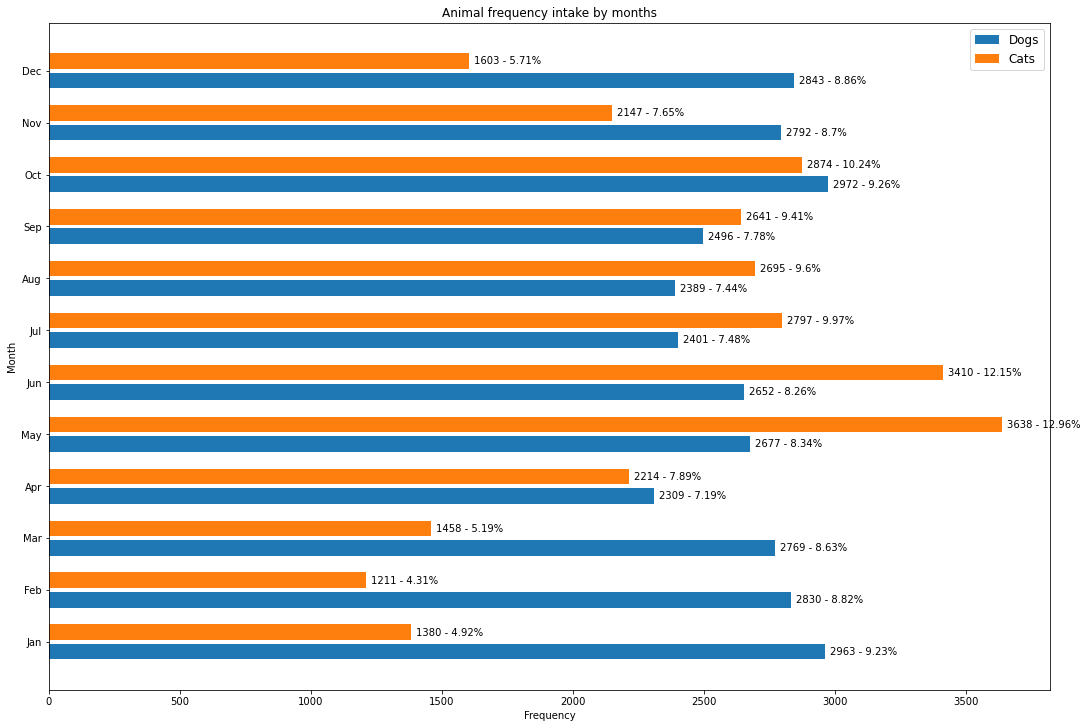

In [9]:
dogs_per_month_intake = dogs_df['intake_month'].value_counts().sort_index().values
dogs_per_month_intake_pc = np.around(dogs_per_month_intake / dogs_df.shape[0] * 100, 2)
cats_per_month_intake = cats_df['intake_month'].value_counts().sort_index().values
cats_per_month_intake_pc = np.around(cats_per_month_intake / cats_df.shape[0] * 100, 2)

data = {
    'Dogs': (dogs_per_month_intake, dogs_per_month_intake_pc),
    'Cats': (cats_per_month_intake, cats_per_month_intake_pc)
}
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plot_bars(data, months, title='Animal frequency intake by months', ylabel='Month')

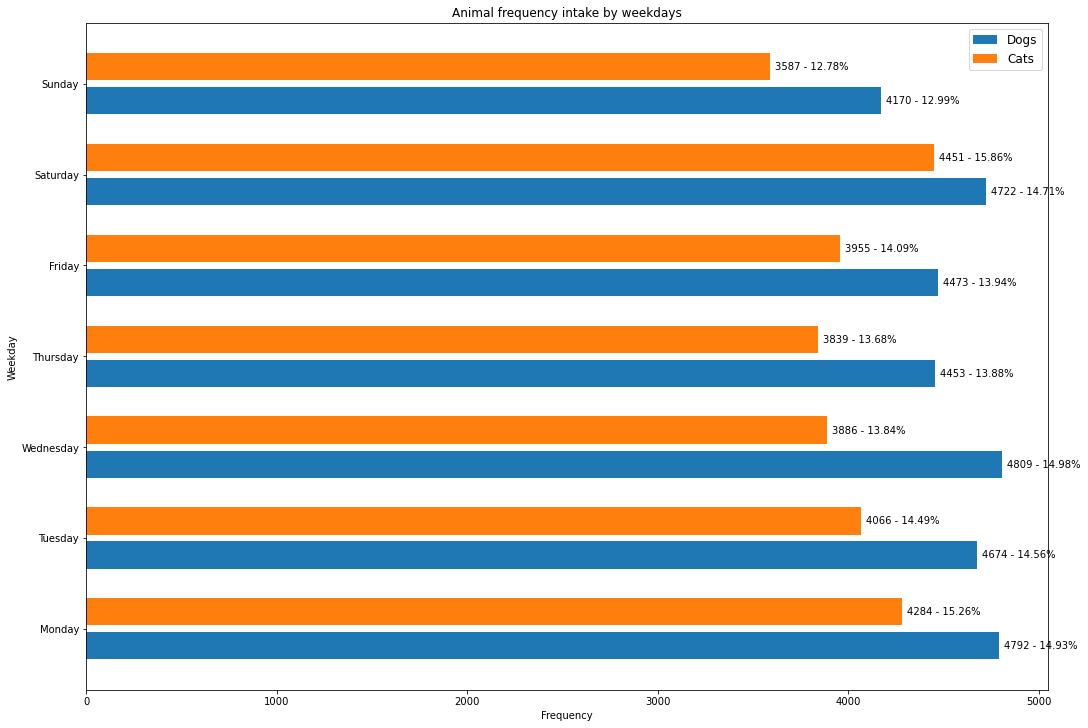

In [10]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dogs_per_weekday_intake = dogs_df['intake_weekday'].value_counts().reindex(weekdays, fill_value=0).values
dogs_per_weekday_intake_pc = np.around(dogs_per_weekday_intake / dogs_df.shape[0] * 100, 2)
cats_per_weekday_intake = cats_df['intake_weekday'].value_counts().reindex(weekdays, fill_value=0).values
cats_per_weekday_intake_pc = np.around(cats_per_weekday_intake / cats_df.shape[0] * 100, 2)

data = {
    'Dogs': (dogs_per_weekday_intake, dogs_per_weekday_intake_pc),
    'Cats': (cats_per_weekday_intake, cats_per_weekday_intake_pc)
}
plot_bars(data, weekdays, title='Animal frequency intake by weekdays', ylabel='Weekday')

In [11]:
dogs_df[['age_upon_intake_years', 'time_in_shelter_days']].corr()

,age_upon_intake_years,time_in_shelter_days
age_upon_intake_years,1.000000,0.115625
time_in_shelter_days,0.115625,1.000000


In [12]:
cats_df[['age_upon_intake_years', 'time_in_shelter_days']].corr()

,age_upon_intake_years,time_in_shelter_days
age_upon_intake_years,1.000000,0.086583
time_in_shelter_days,0.086583,1.000000


In [13]:
# Color - all animals, dogs, cats - dogs and cats have different colors and prints

def plot_colors_freq_diag(color_col, title_append):
    colors_pc = color_col.value_counts(normalize=True)
    colors_pc_cumsum = np.cumsum(colors_pc.values)
    color_number = np.arange(len(colors_pc_cumsum))
    print(colors_pc)
    
    plt.rcParams["figure.figsize"] = (15, 7)
    
    xstep = 20
    plt.xticks(np.arange(0, 500 + xstep, step = xstep))

    ystep = 0.1
    plt.yticks(np.arange(0, 1 + ystep, step=ystep))

    plt.grid()

    plt.xlabel('Color number')
    plt.ylabel('% of rows')
    plt.title(f'Frequency distribution {title_append}')

    plt.plot(color_number, colors_pc_cumsum)

Black/White            0.108343
Black                  0.090607
Brown Tabby            0.071126
Brown Tabby/White      0.037134
Orange Tabby           0.034108
                         ...   
Blue/Yellow Brindle    0.000017
Gray/Red               0.000017
Buff/Cream             0.000017
Gray/Buff              0.000017
Gold/Gray              0.000017
Name: color, Length: 468, dtype: float64


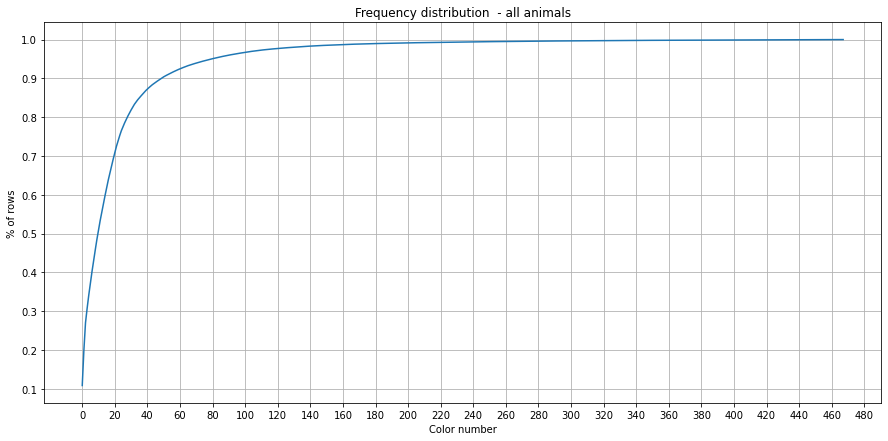

In [14]:
plot_colors_freq_diag(aac_df['color'], title_append=' - all animals')

From the **frequency distribution**, we observe that few color categories have high frequency and
most of the categories have a very low frequency. 
We can restrict one-hot encoding to only top x frequently occurring categories.

Black/White                 0.119995
Tan/White                   0.055464
Black                       0.055059
Brown/White                 0.053501
White                       0.049294
                              ...   
Tan/Brown Brindle           0.000031
Red Tick/Brown Merle        0.000031
Blue Merle/Brown Brindle    0.000031
Blue Cream/Blue Tiger       0.000031
Gold/Gray                   0.000031
Name: color, Length: 305, dtype: float64


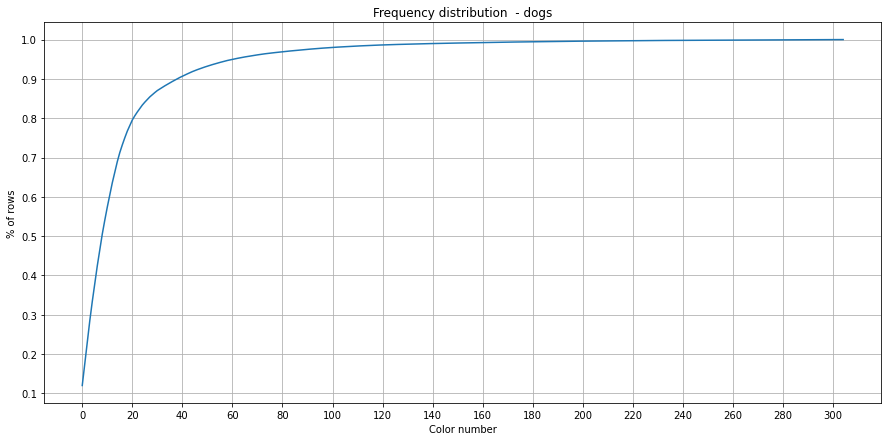

In [15]:
plot_colors_freq_diag(dogs_df['color'], title_append=" - dogs")

**40** top occuring colors covers ~ **90%** of rows for dogs.

Brown Tabby                  0.152451
Black                        0.131253
Black/White                  0.095019
Brown Tabby/White            0.079592
Orange Tabby                 0.073108
                               ...   
Black/Silver Tabby           0.000036
Orange Tabby/Tortie Point    0.000036
Orange Tabby/Black           0.000036
Tricolor/Calico              0.000036
Black Smoke/Black Tiger      0.000036
Name: color, Length: 228, dtype: float64


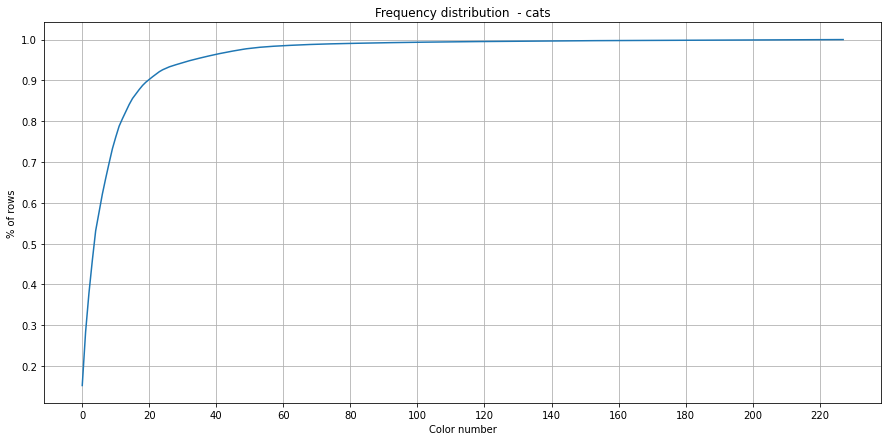

In [16]:
plot_colors_freq_diag(cats_df['color'], title_append=" - cats")

**20** top occuring colors covers ~ **90%** of rows for cats.

In [17]:
def leave_top_colors(top_colors):
    return lambda color: color if color in top_colors else 'Other'

In [18]:
dogs_colors_top_90 = set(dogs_df['color'].value_counts(normalize=True).keys()[:20])
aac_df.loc[filter_dogs, 'color'] = aac_df[filter_dogs]['color'].apply(leave_top_colors(dogs_colors_top_90))
aac_df[filter_dogs]['color'].unique()

array(['Tricolor', 'Black/Tan', 'Black/White', 'Tan/Black', 'Other',
       'Brown/White', 'Tan', 'Black/Brown', 'Brown', 'White',
       'Brown/Black', 'Black', 'Red', 'Brown Brindle/White', 'Tan/White',
       'White/Tan', 'White/Brown', 'Brown Brindle', 'Red/White',
       'White/Black', 'Blue/White'], dtype=object)

In [19]:
cats_colors_top_90 = set(cats_df['color'].value_counts(normalize=True).keys()[:12])
aac_df.loc[filter_cats, 'color'] = aac_df[filter_cats]['color'].apply(leave_top_colors(cats_colors_top_90))
aac_df[filter_cats]['color'].unique()

array(['Brown Tabby/White', 'Black', 'Other', 'Black/White', 'Tortie',
       'Orange Tabby/White', 'Calico', 'Brown Tabby', 'Blue/White',
       'Blue', 'Blue Tabby', 'Torbie', 'Orange Tabby'], dtype=object)

In [20]:
# string columns to lowercase
str_cols = [
    'animal_type',
    'breed',
    'color',
    'intake_weekday',
    'intake_type',
    'intake_condition',
    'sex',
    'reproductive_state_intake', 
    'reproductive_state_outcome'
]

for col in str_cols:
    aac_df[col] = aac_df[col].str.lower()
    
aac_df['intake_type'] = aac_df['intake_type'].str.replace(' ', '_')
aac_df['color'] = aac_df['color'].str.replace(r'[ /]', '_', regex='True')
aac_df.head()

,id,animal_type,breed,intake_month,intake_weekday,color,age_upon_intake_years,intake_type,intake_condition,time_in_shelter_days,outcome_type,reproductive_state_intake,sex,reproductive_state_outcome
3,A047759,dog,dachshund,4,wednesday,tricolor,10.0,owner_surrender,normal,4.970139,Transfer,sterile,male,sterile
11,A197810,cat,american shorthair mix,12,monday,brown_tabby_white,14.0,stray,normal,14.120139,Transfer,sterile,female,sterile
12,A200922,dog,dachshund mix,10,thursday,black_tan,16.0,owner_surrender,normal,49.747917,Adoption,sterile,male,sterile
13,A208755,dog,border collie mix,2,tuesday,black_white,14.0,owner_surrender,sick,0.130556,Euthanasia,sterile,male,sterile
14,A210457,dog,chihuahua shorthair,9,wednesday,tan_black,17.0,public_assist,aged,9.020139,Adoption,sterile,male,sterile


In [21]:
# One hot encoding categorical data - all but color

one_hot_cols = [
    'intake_weekday',
    'intake_month', # although it's a number it can be treated the same as the name of the month
    'intake_type',
    'intake_condition',
    'sex',
    'reproductive_state_intake',
    'reproductive_state_outcome'
]

aac_df_oh = pd.get_dummies(aac_df, columns=one_hot_cols)
aac_df_oh.drop(columns=['sex_unknown', 'reproductive_state_intake_unknown', 'reproductive_state_outcome_unknown'], inplace=True)

In [22]:
# Scale age_upon_intake_years
years = aac_df_oh['age_upon_intake_years']
aac_df_oh['age_upon_intake_years'] = (years-years.min())/(years.max()-years.min())
aac_df_oh

,id,animal_type,breed,color,age_upon_intake_years,time_in_shelter_days,outcome_type,intake_weekday_friday,intake_weekday_monday,intake_weekday_saturday,...,intake_condition_nursing,intake_condition_other,intake_condition_pregnant,intake_condition_sick,sex_female,sex_male,reproductive_state_intake_intact,reproductive_state_intake_sterile,reproductive_state_outcome_intact,reproductive_state_outcome_sterile
3,A047759,dog,dachshund,tricolor,0.454545,4.970139,Transfer,0,0,0,...,0,0,0,0,0,1,0,1,0,1
11,A197810,cat,american shorthair mix,brown_tabby_white,0.636364,14.120139,Transfer,0,1,0,...,0,0,0,0,1,0,0,1,0,1
12,A200922,dog,dachshund mix,black_tan,0.727273,49.747917,Adoption,0,0,0,...,0,0,0,0,0,1,0,1,0,1
13,A208755,dog,border collie mix,black_white,0.636364,0.130556,Euthanasia,0,0,0,...,0,0,0,1,0,1,0,1,0,1
14,A210457,dog,chihuahua shorthair,tan_black,0.772727,9.020139,Adoption,0,0,0,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79664,A769057,cat,domestic shorthair mix,other,0.001743,0.076389,Transfer,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79665,A769058,cat,domestic shorthair mix,blue,0.001743,0.076389,Transfer,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79666,A769059,cat,domestic shorthair mix,blue,0.001743,0.708333,Transfer,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79667,A769060,cat,domestic shorthair mix,tortie,0.001743,0.077083,Transfer,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
aac_df_oh.shape

(60161, 44)

In [24]:
# Create separate datasets for dogs and cats
dogs_df = aac_df_oh[aac_df_oh['animal_type'] == 'dog'].drop(columns=['animal_type'])
cats_df = aac_df_oh[aac_df_oh['animal_type'] == 'cat'].drop(columns=['animal_type'])

In [25]:
# Save datasets

# dogs_df.to_csv('data/dogs-no-breed-info.csv', index=False)
# cats_df.to_csv('data/cats-no-breed-info.csv', index=False)

In [26]:
# Reload datasets

# dogs_df = pd.read_csv('data/dogs-no-breed-info.csv')
# cats_df = pd.read_csv('data/cats-no-breed-info.csv')

# EDA

In [27]:
min_tisd, max_tisd = aac_df_oh['time_in_shelter_days'].min(), aac_df_oh['time_in_shelter_days'].max()
dogs_tisd = dogs_df['time_in_shelter_days']
cats_tisd = cats_df['time_in_shelter_days']
n_dogs = dogs_df.shape[0]
n_cats = cats_df.shape[0]

[]

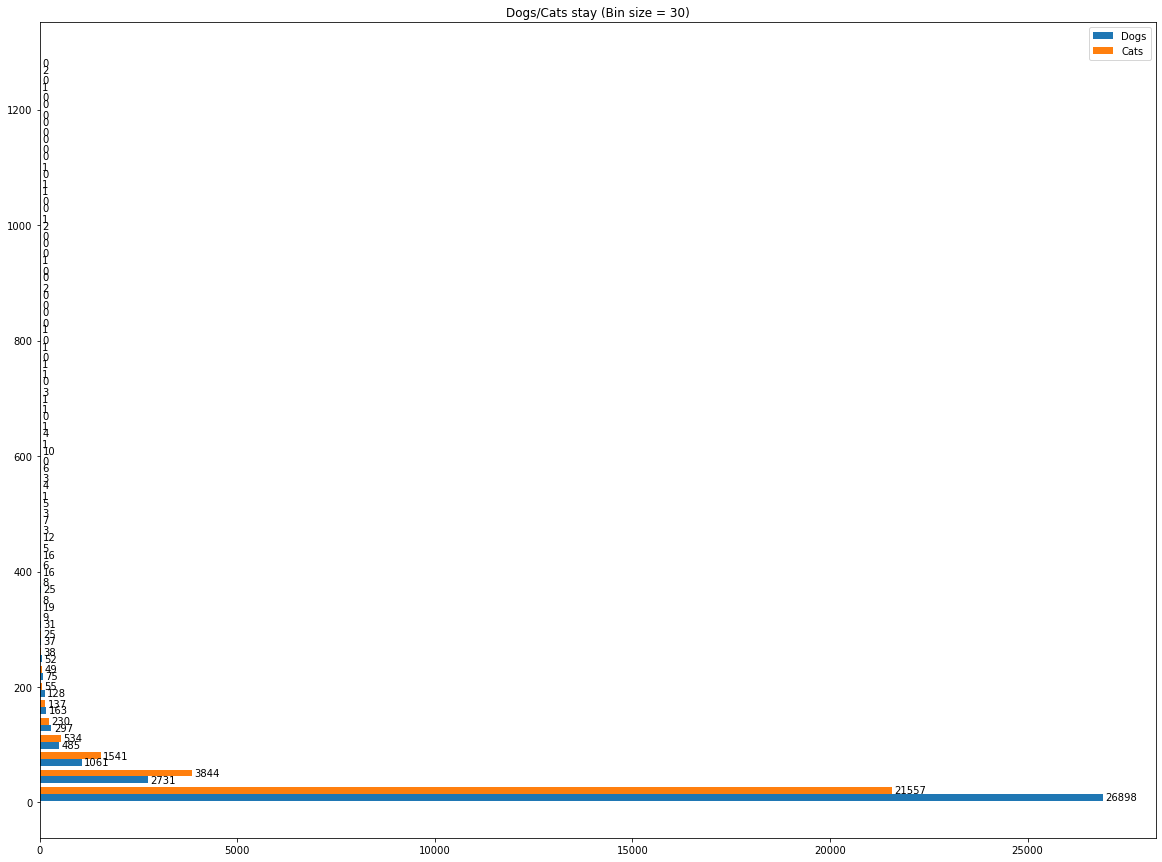

In [28]:
# initial test - see number of animals by duration of stay in aac (in months - 30 days )
bin_size = 30
bins = np.arange(min_tisd, max_tisd + bin_size, bin_size)

plt.rcParams["figure.figsize"] = (20, 15)

_, _, bars = plt.hist([dogs_tisd, cats_tisd], bins, label=('Dogs', 'Cats'), orientation='horizontal')
for bar in bars:
    plt.bar_label(bar, padding=2.5)

plt.title(f'Dogs/Cats stay (Bin size = {bin_size})')
plt.legend(loc='upper right')

plt.plot()

In [91]:
def plot_animal_tisd_bars(animal_tisd, bins): # animal time in shelter in days    
    data = {}
    for animal, tisd in animal_tisd.items():
        animal_hist, _ = np.histogram(tisd, bins)
        animal_hist_t_pc = np.around(animal_hist / len(tisd) * 100, 2)
        animal_hist_r_pc = np.around(animal_hist / np.sum(animal_hist) * 100, 2)
        data[animal] = (animal_hist, animal_hist_t_pc, animal_hist_r_pc) 
        
    n_bins = len(bins)

    class_names = []
    for i in range(n_bins - 1):
        class_name = f'{bins[i]}-{bins[i+1]} days' if i != n_bins - 2 else f'> {bins[i]} days'
        class_names.append(class_name)

    x = np.arange(len(class_names))  # the label locations
    width = 0.3  # the width of the bars
    multiplier = 0
    multiplier_step = 1.25 # add space between grouped bars - 1 is base

    plt.rcParams["figure.figsize"] = (15, 7)

    fig, ax = plt.subplots(constrained_layout=True)

    for animal, (counts, t_percents, r_percents) in data.items():
        offset = width * multiplier
        rects = ax.barh(x + offset, counts, width, label=f'{animal} ({len(animal_tisd[animal])})')
        bar_labels = [f'C: {count} - T: {t_pc}% - R: {r_pc}%' for count, t_pc, r_pc  in zip(counts, t_percents, r_percents)]
        ax.bar_label(rects, bar_labels, padding=5)
        multiplier += multiplier_step

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title('Animal frequency by length of stay (classification period)')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Length of stay')
    yticks_pos = x if len(animal_tisd) == 1 else x + width*multiplier_step/2
    ax.set_yticks(yticks_pos, class_names)
    ax.legend(loc='upper right', prop={'size': 12})
    plt.plot()

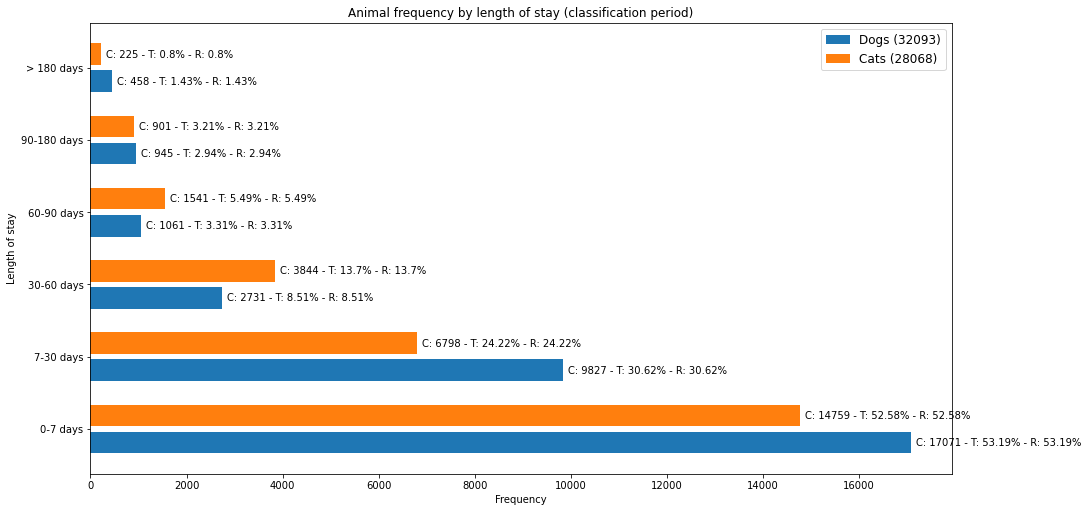

In [92]:
# notice how imbalanced dataset is by our goal label

animal_tisd = {'Dogs': dogs_tisd, 'Cats': cats_tisd}
bins = (0, 7, 30, 60, 90, 180, max_tisd + 1)

plot_animal_tisd_bars(animal_tisd, bins)


# Dogs

In [31]:
target_names = ['below_median', 'above_median']

def print_report(X, y, clf, target_names):
    random_state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

In [32]:
# We focus on dogs now
dogs_tisd_median = round(np.median(dogs_tisd))
print(f'Roughly half of dogs spend less then {dogs_tisd_median} days in shelter')

Roughly half of dogs spend less then 6 days in shelter


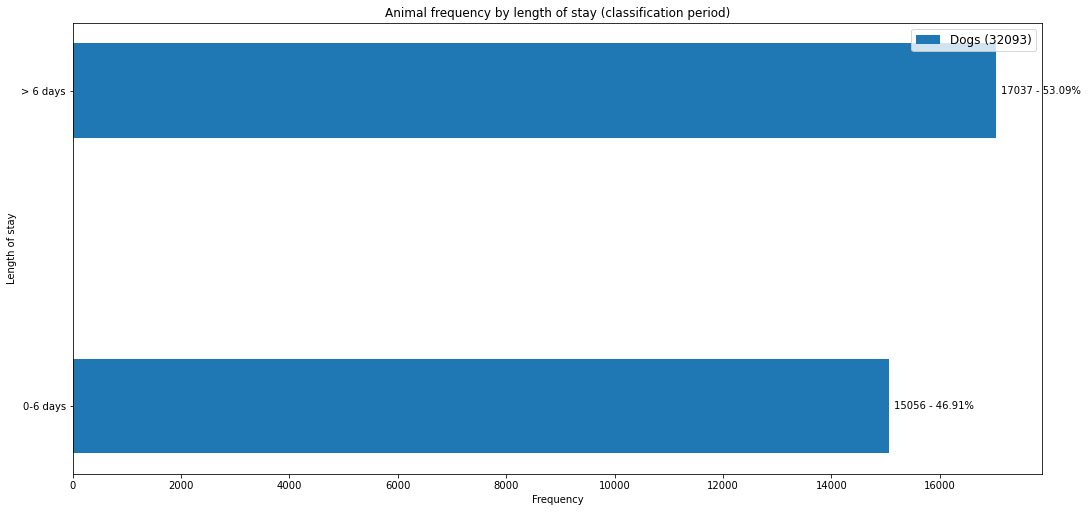

In [33]:
animal_tisd = {'Dogs': dogs_tisd}
bins = (0, dogs_tisd_median, max_tisd + 1)
plot_animal_tisd_bars(animal_tisd, bins)

In [34]:
# try to create hierarchy of models
# first detect whether dog will stay in shelter for less than 5 days
dogs_df_ml = pd.get_dummies(dogs_df, columns=['color'])
dogs_df_ml = dogs_df_ml.drop(columns=['id', 'breed', 'outcome_type']) # ignoring these for now
dogs_df_ml.columns

Index(['age_upon_intake_years', 'time_in_shelter_days',
       'intake_weekday_friday', 'intake_weekday_monday',
       'intake_weekday_saturday', 'intake_weekday_sunday',
       'intake_weekday_thursday', 'intake_weekday_tuesday',
       'intake_weekday_wednesday', 'intake_month_1', 'intake_month_2',
       'intake_month_3', 'intake_month_4', 'intake_month_5', 'intake_month_6',
       'intake_month_7', 'intake_month_8', 'intake_month_9', 'intake_month_10',
       'intake_month_11', 'intake_month_12', 'intake_type_euthanasia_request',
       'intake_type_owner_surrender', 'intake_type_public_assist',
       'intake_type_stray', 'intake_condition_aged', 'intake_condition_feral',
       'intake_condition_injured', 'intake_condition_normal',
       'intake_condition_nursing', 'intake_condition_other',
       'intake_condition_pregnant', 'intake_condition_sick', 'sex_female',
       'sex_male', 'reproductive_state_intake_intact',
       'reproductive_state_intake_sterile',
       'reproduc

In [35]:
# create prediction goal
y = (dogs_df_ml['time_in_shelter_days'] > dogs_tisd_median).astype(int)
X = dogs_df_ml.drop(columns=['time_in_shelter_days'])

In [36]:
baseline_clf = DummyClassifier(strategy='uniform', random_state=0)
print_report(X, y, baseline_clf, target_names)

              precision    recall  f1-score   support

below_median       0.47      0.49      0.48      4998
above_median       0.53      0.50      0.52      5593

    accuracy                           0.50     10591
   macro avg       0.50      0.50      0.50     10591
weighted avg       0.50      0.50      0.50     10591

[[2454 2544]
 [2769 2824]]


In [37]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
print_report(X, y, clf1, target_names)

              precision    recall  f1-score   support

below_median       0.70      0.57      0.63      4998
above_median       0.67      0.78      0.72      5593

    accuracy                           0.68     10591
   macro avg       0.68      0.67      0.67     10591
weighted avg       0.68      0.68      0.68     10591

[[2850 2148]
 [1233 4360]]


In [38]:
clf2 = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=0)
print_report(X, y, clf2, target_names)

              precision    recall  f1-score   support

below_median       0.68      0.52      0.59      4998
above_median       0.65      0.78      0.71      5593

    accuracy                           0.66     10591
   macro avg       0.66      0.65      0.65     10591
weighted avg       0.66      0.66      0.65     10591

[[2594 2404]
 [1221 4372]]


In [39]:
clf3 = GaussianNB()
print_report(X, y, clf3, target_names)

              precision    recall  f1-score   support

below_median       0.62      0.38      0.47      4998
above_median       0.59      0.79      0.67      5593

    accuracy                           0.60     10591
   macro avg       0.60      0.59      0.57     10591
weighted avg       0.60      0.60      0.58     10591

[[1920 3078]
 [1176 4417]]


# Cats

In [40]:
# We focus on cast now

cats_tisd_median = round(np.median(cats_tisd))
print(f'Roughly half of cats spend less then {cats_tisd_median} days in shelter')

Roughly half of cats spend less then 6 days in shelter


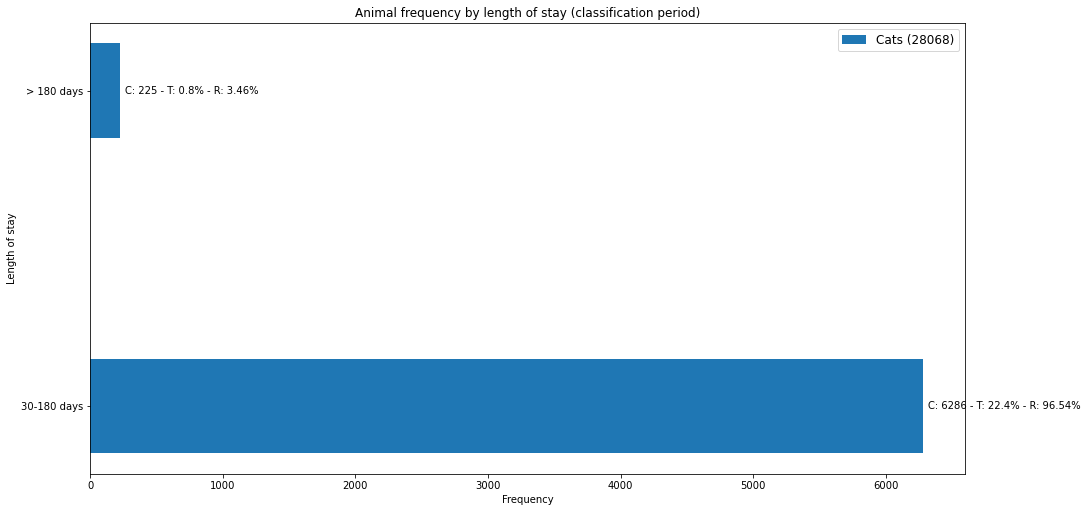

In [170]:
animal_tisd = {'Cats': cats_tisd}
# bins = (0, cats_tisd_median, max_tisd + 1)
bins = (30, 180, max_tisd + 1)

plot_animal_tisd_bars(animal_tisd, bins)

In [42]:
# try to create hierarchy of models
# first detect whether dog will stay in shelter for less than 5 days
cats_df_ml = pd.get_dummies(cats_df, columns=['color'])
cats_df_ml = cats_df_ml.drop(columns=['id', 'breed', 'outcome_type']) # ignoring these for now

cats_df_ml.columns

Index(['age_upon_intake_years', 'time_in_shelter_days',
       'intake_weekday_friday', 'intake_weekday_monday',
       'intake_weekday_saturday', 'intake_weekday_sunday',
       'intake_weekday_thursday', 'intake_weekday_tuesday',
       'intake_weekday_wednesday', 'intake_month_1', 'intake_month_2',
       'intake_month_3', 'intake_month_4', 'intake_month_5', 'intake_month_6',
       'intake_month_7', 'intake_month_8', 'intake_month_9', 'intake_month_10',
       'intake_month_11', 'intake_month_12', 'intake_type_euthanasia_request',
       'intake_type_owner_surrender', 'intake_type_public_assist',
       'intake_type_stray', 'intake_condition_aged', 'intake_condition_feral',
       'intake_condition_injured', 'intake_condition_normal',
       'intake_condition_nursing', 'intake_condition_other',
       'intake_condition_pregnant', 'intake_condition_sick', 'sex_female',
       'sex_male', 'reproductive_state_intake_intact',
       'reproductive_state_intake_sterile',
       'reproduc

In [43]:
y = (cats_df_ml['time_in_shelter_days'] > cats_tisd_median).astype(int)
X = cats_df_ml.drop(columns=['time_in_shelter_days'])

In [44]:
baseline_clf = DummyClassifier(strategy='uniform', random_state=0)
print_report(X, y, baseline_clf, target_names)

              precision    recall  f1-score   support

below_median       0.51      0.50      0.50      4680
above_median       0.50      0.51      0.50      4583

    accuracy                           0.50      9263
   macro avg       0.50      0.50      0.50      9263
weighted avg       0.50      0.50      0.50      9263

[[2319 2361]
 [2251 2332]]


In [45]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=0)
print_report(X, y, clf1, target_names=target_names)

              precision    recall  f1-score   support

below_median       0.80      0.76      0.78      4680
above_median       0.77      0.81      0.79      4583

    accuracy                           0.78      9263
   macro avg       0.78      0.78      0.78      9263
weighted avg       0.78      0.78      0.78      9263

[[3540 1140]
 [ 868 3715]]


In [46]:
clf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
print_report(X, y, clf2, target_names)

              precision    recall  f1-score   support

below_median       0.81      0.72      0.76      4680
above_median       0.74      0.83      0.79      4583

    accuracy                           0.78      9263
   macro avg       0.78      0.78      0.77      9263
weighted avg       0.78      0.78      0.77      9263

[[3361 1319]
 [ 765 3818]]
